# PN2V Training
Here we will use the estimated noise model (from the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```) and train a PN2V network on single noisy images.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

from ppn2v.unet.model import UNet
from ppn2v import utils, training
from ppn2v.noise_models import histNoiseModel, gaussianMixtureNoiseModel

from tifffile import imread
import os
import urllib
import zipfile
import torch
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets from  https://owncloud.mpi-cbg.de/index.php/s/31ZiGfcLmJXZk3X/download and created a noise model (either GMM based or histogram based, using either the notebook ```1a_CreateNoiseModel_GMM.ipynb``` or ```1b_CreateNoiseModel_Histogram.ipynb```). Ensure that for Mouse skull nuclei, the data to be denoised is named ```example2_digital_offset300.tif``` and not the slide edge data. For your dataset, ensure that you load the right data. 

In [2]:
path='../../../data/Mouse skull nuclei/'
# Load the training data
data=imread(path+'example2_digital_offset300.tif')
dataName='mouseskullnuclei'

Uncomment the pertinent `nameNoiseModel` to choose the noiseModel of interest

In [3]:
nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
#nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
if('HistNoiseModel' in namePN2VModel):
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
elif('GMMNoiseModel' in namePN2VModel):
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params = params, device = device)
  

### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 5.0889047384262085+-(2SEM)0.08061664092908478      
Epoch 1 finished      
avg. loss: 4.549095582962036+-(2SEM)0.04058349074431861      
Epoch 2 finished      
avg. loss: 4.282945919036865+-(2SEM)0.043495534308526124      
Epoch 3 finished      
avg. loss: 4.1398589491844175+-(2SEM)0.03233645017885947      
Epoch 4 finished      
avg. loss: 4.003533673286438+-(2SEM)0.0442765586708031      
Epoch 5 finished      
avg. loss: 3.914688456058502+-(2SEM)0.03711245206442097      
Epoch 6 finished      
avg. loss: 3.855365478992462+-(2SEM)0.04274355902840689      
Epoch 7 finished      
avg. loss: 3.8114134907722472+-(2SEM)0.057032571931991884      
Epoch 8 finished      
avg. loss: 3.782061684131622+-(2SEM)0.05517168901519913      
Epoch 9 finished      
avg. loss: 3.722582221031189+-(2SEM)0.05233415428670991      
Epoch 10 finished      
avg. loss: 3.7572463750839233+-(2SEM)0.04108953392604143      
Epoch 11 finished      
avg. loss: 3.7254247069358826+-(2SE

Epoch 93 finished      
avg. loss: 3.599810206890106+-(2SEM)0.06651840637551523      
Epoch 94 finished      
avg. loss: 3.601294016838074+-(2SEM)0.0637220712521573      
Epoch    95: reducing learning rate of group 0 to 6.2500e-05.
Epoch 95 finished      
avg. loss: 3.5388511419296265+-(2SEM)0.06120818382282163      
Epoch 96 finished      
avg. loss: 3.638109493255615+-(2SEM)0.07063400056974496      
Epoch 97 finished      
avg. loss: 3.599313759803772+-(2SEM)0.06955462361828868      
Epoch 98 finished      
avg. loss: 3.5696126222610474+-(2SEM)0.07018574716166265      
Epoch 99 finished      
avg. loss: 3.6253918290138243+-(2SEM)0.068547464400692      
Epoch 100 finished      
avg. loss: 3.628329169750214+-(2SEM)0.05777566540234412      
Epoch 101 finished      
avg. loss: 3.5595859050750733+-(2SEM)0.057259090631711515      
Epoch 102 finished      
avg. loss: 3.619810426235199+-(2SEM)0.058691683500281706      
Epoch 103 finished      
avg. loss: 3.5837844014167786+-(2SEM)0.05723712

Epoch 182 finished      
avg. loss: 3.5360336542129516+-(2SEM)0.05867412403520362      
Epoch 183 finished      
avg. loss: 3.575426459312439+-(2SEM)0.07012046504140132      
Epoch   184: reducing learning rate of group 0 to 4.8828e-07.
Epoch 184 finished      
avg. loss: 3.5772958993911743+-(2SEM)0.058245500186641735      
Epoch 185 finished      
avg. loss: 3.5620618581771852+-(2SEM)0.06465960273374302      
Epoch 186 finished      
avg. loss: 3.5711548209190367+-(2SEM)0.06315915703451859      
Epoch 187 finished      
avg. loss: 3.533535623550415+-(2SEM)0.05948480305337793      
Epoch 188 finished      
avg. loss: 3.541157865524292+-(2SEM)0.055210382850876545      
Epoch 189 finished      
avg. loss: 3.6514349699020388+-(2SEM)0.07864054212987714      
Epoch 190 finished      
avg. loss: 3.566830635070801+-(2SEM)0.06877941812712098      
Epoch 191 finished      
avg. loss: 3.5865529656410216+-(2SEM)0.06325749475046766      
Epoch 192 finished      
avg. loss: 3.522579216957092+-(2SEM

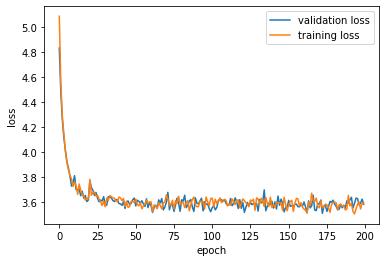

In [6]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()